## Fashion MNIST
---
### Classifying Images of Clothing
---

### Import Dependancies

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import math
import numpy as np
import matplotlib.pyplot as plt
import logging 
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Import Fashion MNIST Data
---
* The Fashion MNIST dataset contains 70,000 grayscale images in 10 categories.

In [7]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

# We will use 60k images to train and 10k to test
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete94KSW7/fashion_mnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete94KSW7/fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [12]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Explore the Data

In [15]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of testing examples:  {}".format(num_test_examples))

Number of training examples: 60000
Number of testing examples:  10000


### Preprocess the Data
* Normalize the pixel range

In [16]:
def normalize(images, labels):
  images=tf.cast(images, tf.float32)
  images /=255
  return images, labels

  # Map function applies the normalize function to each element in the test/train datasets
  train_dataset = train_dataset.map(normalize)
  test_dataset = test_dataset.map(normalize)

  # The first time you use the dataset, the images will be loaded from disk
  # Caching will keep them in memory, making training faster
  train_dataset = train_dataset.cache()
  test_dataset = test_dataset.cache()

### Explore Processed Data

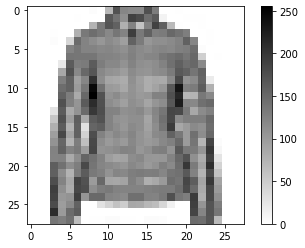

In [17]:
# Take a single image and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image 
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

* Display the first 25 images from training set and display the calss below each image. Verify format is correct.

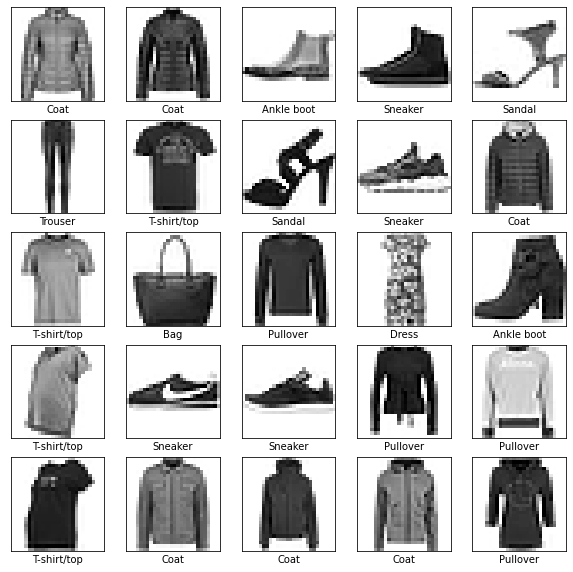

In [18]:
plt.figure(figsize=(10,10))
for i, (image,label) in enumerate(test_dataset.take(25)):
  image=image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
plt.show()

### Build the Model
---
* The basic building block of a neural network is the layer. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

This network has three layers:

input tf.keras.layers.Flatten — This layer transforms the images from a 2d-array of 28  ×  28 pixels, to a 1d-array of 784 pixels (28*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.

"hidden" tf.keras.layers.Dense— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

output tf.keras.layers.Dense — A 128-neuron, followed by 10-node softmax layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range [0, 1], representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

### Compile the Model


In [23]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

### Train the Model

In [24]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [25]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 10s 2ms/step - loss: 10.1516 - accuracy: 0.6675
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7508 - accuracy: 0.7424
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6342 - accuracy: 0.7785
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5381 - accuracy: 0.8145
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5284 - accuracy: 0.8183


### Evaluate Accuracy

In [26]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.7226 - accuracy: 0.7631
Accuracy on test dataset: 0.7631000280380249


### Make Predictions & Explore

In [27]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [28]:
predictions.shape

(32, 10)

In [29]:
predictions[0]

array([8.5006395e-06, 1.6294616e-06, 6.1171670e-02, 2.4168690e-04,
       9.2797643e-01, 1.3825086e-20, 1.0599591e-02, 1.9644112e-33,
       4.8634928e-07, 2.9031773e-26], dtype=float32)

In [30]:
test_labels[0]

4

In [32]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img=predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0],cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color='blue'
  else:
    color='red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)
    
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color='#777777')
  plt.ylim([0,1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

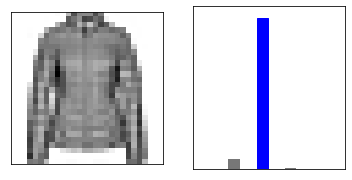

In [33]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

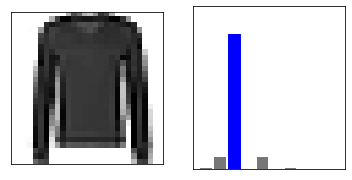

In [34]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

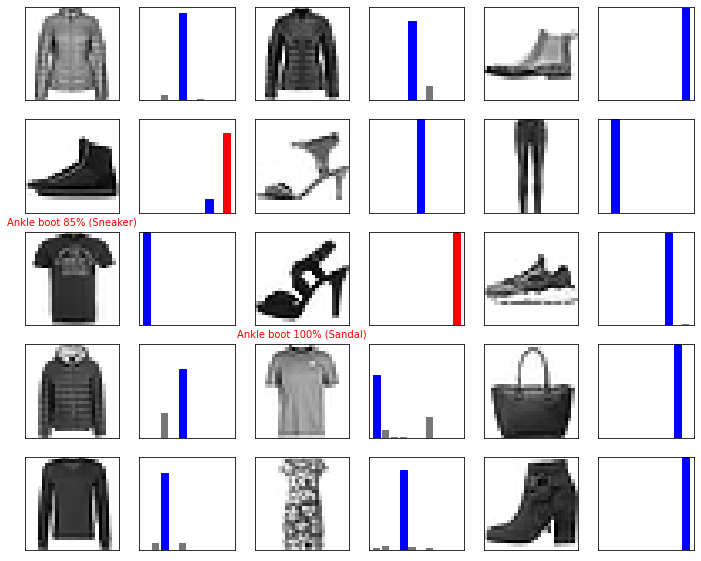

In [35]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue and incorrect predictions in red

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [36]:
# Grab an image from the test dataset
img = test_images[0]
print(img.shape)

(28, 28, 1)


In [37]:
# Add the image to a batch where it's the only memeber
img=np.array([img])
print(img.shape)

(1, 28, 28, 1)


In [38]:
# Predict the image
predictions_single = model.predict(img)
print(predictions_single)

[[8.5006404e-06 1.6294618e-06 6.1171677e-02 2.4168647e-04 9.2797655e-01
  1.3825088e-20 1.0599593e-02 1.9644114e-33 4.8634843e-07 2.9031662e-26]]


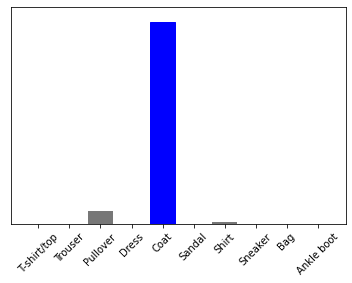

In [40]:
# Return chart of predictions
plot_value_array(0, predictions_single, test_labels)
_=plt.xticks(range(10), class_names, rotation=45)

In [41]:
np.argmax(predictions_single[0])

4